In [100]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('cifar10_runs/layer_wise')




## Ideas

![](./assets/1.png)

## Utils

In [101]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

## Device

In [102]:
devices = ["cuda:0", "cuda:1"]

## Preparing data

### Data transforms

In [103]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 4


In [104]:
train_dataset = CIFAR10(root="./data", download=False, train=True, transform=data_transforms)

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,
                          shuffle=True, )

classes = train_dataset.classes

classes


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

c:\Users\hoang\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


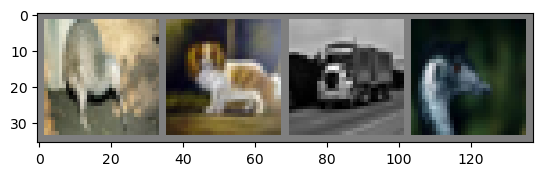

In [105]:
sample = iter(train_loader)

img, label = next(sample)


img_grid = torchvision.utils.make_grid(img)

matplotlib_imshow(img_grid, one_channel=False)

writer.add_image('CIFAR_10_IMAGES', img_grid)



## Model preparing

In [106]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # VGG16
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 8, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
        
        self.fc1 = nn.Linear(400, 60)
        self.fc2 = nn.Linear(120, 42)
        
        # Not apply layer-wise
        self.fc3 = nn.Linear(84, 10)
        
        
        self.submodule_1 = [self.conv1, self.conv1]
        
        self.submodule_2 = [self.conv2, self.conv2]
        
        self.submodule_3 = [self.fc1, self.fc1]
        
        self.submodule_4 = [self.fc2, self.fc2]
        
        
        self.submodules = {
            "conv_module_1":self.submodule_1,
            "conv_module_2":self.submodule_2,
            "fc_module_1":self.submodule_3,
            "fc_module_2":self.submodule_4
        }
    
    def forward(self, x):
        out = x
        for submodule_key, submodule in self.submodules.items():
            partition_out = []
            if submodule_key == "fc_module_1":
                    out = out.reshape(out.size(0), -1)
            for partition in submodule:
                input_partition = out.clone()
                output_part = partition(input_partition)
                partition_out.append(output_part)
               
            # Concatening
            out = torch.cat(partition_out, dim=1)
            if "fc" in submodule_key:
                out = nn.functional.relu(out)
        out = self.fc3(out)
        # out = nn.Softmax(out)    
        
        
        return out

In [107]:
model = LeNet()

writer.add_graph(model, img)
writer.close()

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]             228
         MaxPool2d-2            [-1, 3, 14, 14]               0
            Conv2d-3            [-1, 3, 28, 28]             228
         MaxPool2d-4            [-1, 3, 14, 14]               0
            Conv2d-5            [-1, 8, 10, 10]           1,208
         MaxPool2d-6              [-1, 8, 5, 5]               0
            Conv2d-7            [-1, 8, 10, 10]           1,208
         MaxPool2d-8              [-1, 8, 5, 5]               0
            Linear-9                   [-1, 60]          24,060
           Linear-10                   [-1, 60]          24,060
           Linear-11                   [-1, 42]           5,082
           Linear-12                   [-1, 42]           5,082
           Linear-13                   [-1, 10]             850
Total params: 62,006
Trainable params: 

## Helper

In [108]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [nn.functional.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

## Training

In [109]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [110]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...
            print(running_loss / 1000)
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(train_loader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=epoch * len(train_loader) + i)
            running_loss = 0.0
print('Finished Training')

2.173698675751686
1.9781262597441673
1.8555227502584457
1.7944832818508147
1.71164569196105
1.6776011537611484
1.640101407751441
1.6250789092332125
1.608989967942238
1.605187964707613
1.5538346541821957
1.5317660312354564
Finished Training
